In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tensorflow.python import debug as tf_debug

%matplotlib inline

/home/rluo/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
h1_dim = 256
h2_dim = 512
dim = 100
batch_size = 64

In [3]:
def generator_(gen_weights, z_noise):
    w1, b1, w2, b2, w3, b3 = gen_weights
    h1 = tf.nn.relu(tf.matmul(z_noise, w1) + b1)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
    h3 = tf.matmul(h2, w3) + b3
    out_gen = tf.nn.sigmoid(h3)
    return out_gen
    
def generator_weights():
    w1 = tf.Variable(tf.truncated_normal([dim, h1_dim], stddev=0.1), name="w1_g", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h1_dim]), name="b1_g", dtype=tf.float32)
    w2 = tf.Variable(tf.truncated_normal([h1_dim, h2_dim], stddev=0.1), name="w2_g", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h2_dim]), name="b2_g", dtype=tf.float32)
    w3 = tf.Variable(tf.truncated_normal([h2_dim, 28 * 28], stddev=0.1), name="w3_g", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([28*28]), name="b3_g", dtype=tf.float32)
    weights_g = [w1, b1, w2, b2, w3, b3]
    return weights_g

In [4]:
def discriminator_(x, disc_weights, keep_prob):
    w1, b1, w2, b2, w3, b3 = disc_weights
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x, w1) + b1), keep_prob)
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1,w2) + b2), keep_prob)
    h3 = tf.matmul(h2, w3) + b3
    y = tf.nn.sigmoid(h3)
    return y
    
def discriminator_weights():
    w1 = tf.Variable(tf.truncated_normal([28*28, h2_dim], stddev=0.1), name="w1_d", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h2_dim]), name="b1_d", dtype=tf.float32)
    w2 = tf.Variable(tf.truncated_normal([h2_dim, h1_dim], stddev=0.1), name="w2_d", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h1_dim]), name="b2_d", dtype=tf.float32)
    w3 = tf.Variable(tf.truncated_normal([h1_dim, 1], stddev=0.1), name="w3_d", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([1]), name="b3_d", dtype=tf.float32)

    weights_d = [w1, b1, w2, b2, w3, b3]
    return weights_d

In [ ]:
with tf.device('/device:GPU:0'):


    # Read the MNIST datadet
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    ## Place holder for the real images
    x = tf.placeholder(tf.float32, [batch_size, 28*28], name="x_data")
    ## Place holder for the noise
    z_noise = tf.placeholder(tf.float32, [batch_size, dim], name="z_prior")
    ## Dropout probability
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    weights_g = generator_weights()
    # generate the output op for    generator and also define the weights.
    out_gen = generator_(weights_g, z_noise)
    # Define the ops and weights for Discriminator
    weights_d = discriminator_weights()
    y_data = discriminator_(x, weights_d, keep_prob)
    y_fake = discriminator_(out_gen, weights_d, keep_prob)

    eps = tf.random_uniform([batch_size, 1])
    x_hat = eps * x + (1 - eps) * out_gen
    y_mid = discriminator_(x_hat, weights_d, keep_prob)

    lam = 10
    gradients = tf.gradients(y_mid, x_hat)[0]
    disc_loss = tf.reduce_mean(y_fake) - tf.reduce_mean(y_data) + lam * tf.reduce_mean(tf.square(tf.norm(gradients, axis=1) - 1))

    gen_loss = -tf.reduce_mean(y_fake)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_trainer = tf.train.AdamOptimizer(0.0001, 0.1, 0.9).minimize(disc_loss, var_list=weights_d)
        g_trainer = tf.train.AdamOptimizer(0.0001, 0.1, 0.9).minimize(gen_loss, var_list=weights_g)
    
    init = tf.global_variables_initializer()
    
    disc_grad = tf.gradients(disc_loss, weights_d)
    gen_grad = tf.gradients(gen_loss, weights_g)

    
gpu_options = tf.GPUOptions(allow_growth=False)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


iter: 1000 cost of discriminator -0.29523194 cost of generator -0.35617
mean predicted prob for actual data: 0.79538494348526, mean predicted prob for fake data: 0.35616999864578247


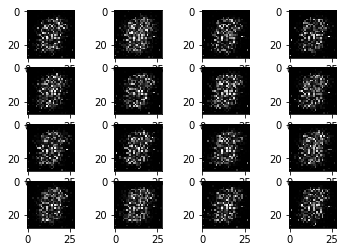

iter: 2000 cost of discriminator -0.18347406 cost of generator -0.39626834
mean predicted prob for actual data: 0.8291741609573364, mean predicted prob for fake data: 0.3962683379650116


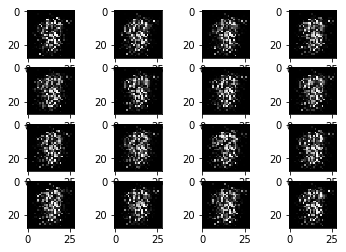

iter: 3000 cost of discriminator -0.28571078 cost of generator -0.3023672
mean predicted prob for actual data: 0.7033874988555908, mean predicted prob for fake data: 0.3023672103881836


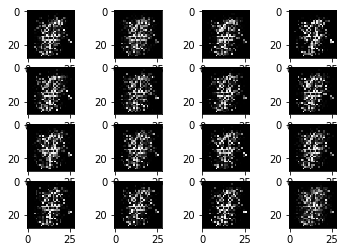

iter: 4000 cost of discriminator -0.31833318 cost of generator -0.3425874
mean predicted prob for actual data: 0.7010750770568848, mean predicted prob for fake data: 0.342587411403656


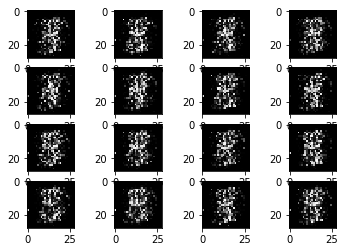

iter: 5000 cost of discriminator -0.28546458 cost of generator -0.30249768
mean predicted prob for actual data: 0.674014687538147, mean predicted prob for fake data: 0.3024976849555969


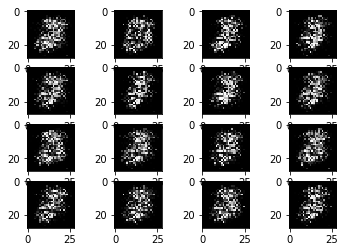

iter: 6000 cost of discriminator -0.2649932 cost of generator -0.30056387
mean predicted prob for actual data: 0.653573751449585, mean predicted prob for fake data: 0.30056387186050415


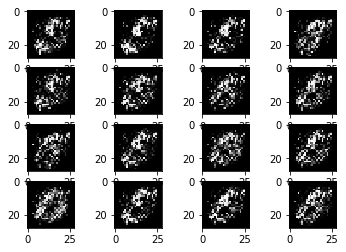

iter: 7000 cost of discriminator -0.2778666 cost of generator -0.28754348
mean predicted prob for actual data: 0.6638933420181274, mean predicted prob for fake data: 0.28754347562789917


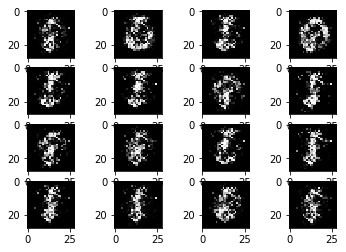

iter: 8000 cost of discriminator -0.21004666 cost of generator -0.3497571
mean predicted prob for actual data: 0.6110604405403137, mean predicted prob for fake data: 0.3497571051120758


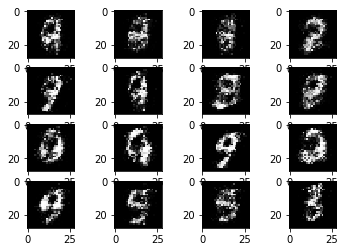

iter: 9000 cost of discriminator -0.2989911 cost of generator -0.35189015
mean predicted prob for actual data: 0.6953551173210144, mean predicted prob for fake data: 0.3518901467323303


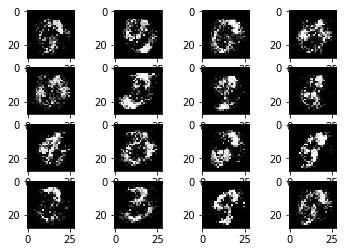

iter: 10000 cost of discriminator -0.2501598 cost of generator -0.4024117
mean predicted prob for actual data: 0.7225437164306641, mean predicted prob for fake data: 0.40241169929504395


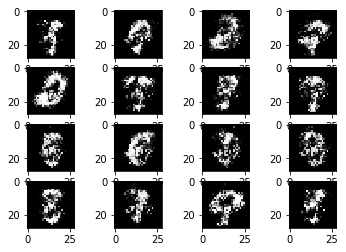

iter: 11000 cost of discriminator -0.24643606 cost of generator -0.43060213
mean predicted prob for actual data: 0.7520766258239746, mean predicted prob for fake data: 0.43060213327407837


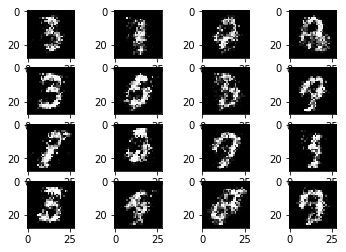

iter: 12000 cost of discriminator -0.24420099 cost of generator -0.33153072
mean predicted prob for actual data: 0.6874454617500305, mean predicted prob for fake data: 0.33153071999549866


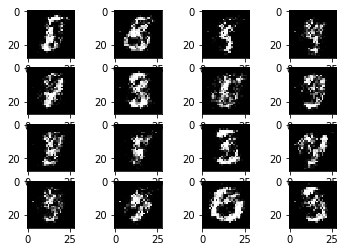

iter: 13000 cost of discriminator -0.14420804 cost of generator -0.4837929
mean predicted prob for actual data: 0.828156054019928, mean predicted prob for fake data: 0.48379290103912354


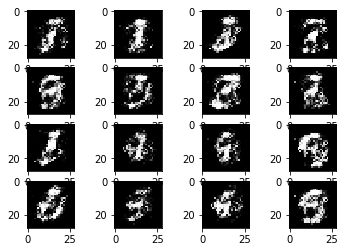

iter: 14000 cost of discriminator -0.21606024 cost of generator -0.43282467
mean predicted prob for actual data: 0.7651698589324951, mean predicted prob for fake data: 0.43282467126846313


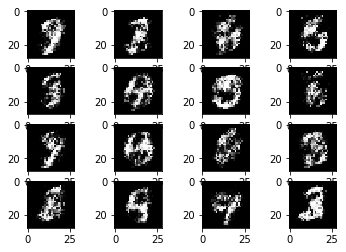

iter: 15000 cost of discriminator -0.25569704 cost of generator -0.39488363
mean predicted prob for actual data: 0.7185719013214111, mean predicted prob for fake data: 0.3948836326599121


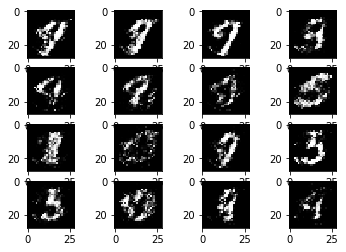

iter: 16000 cost of discriminator -0.31658813 cost of generator -0.35682842
mean predicted prob for actual data: 0.7435814738273621, mean predicted prob for fake data: 0.3568284213542938


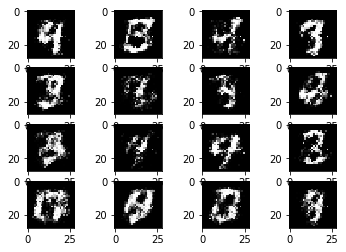

iter: 17000 cost of discriminator -0.30958357 cost of generator -0.32206535
mean predicted prob for actual data: 0.718475341796875, mean predicted prob for fake data: 0.3220653533935547


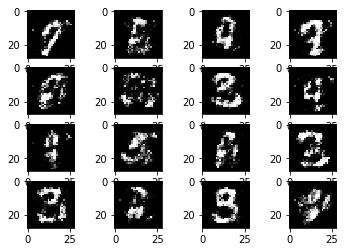

iter: 18000 cost of discriminator -0.26782894 cost of generator -0.35449487
mean predicted prob for actual data: 0.7232142686843872, mean predicted prob for fake data: 0.3544948697090149


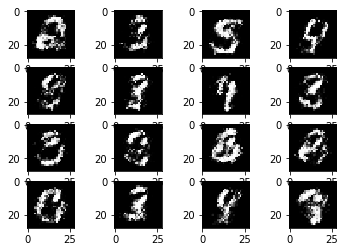

iter: 19000 cost of discriminator -0.21751243 cost of generator -0.40600353
mean predicted prob for actual data: 0.7389940619468689, mean predicted prob for fake data: 0.40600353479385376


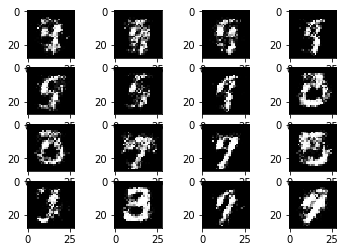

iter: 20000 cost of discriminator -0.22999786 cost of generator -0.36889386
mean predicted prob for actual data: 0.7037982940673828, mean predicted prob for fake data: 0.3688938617706299


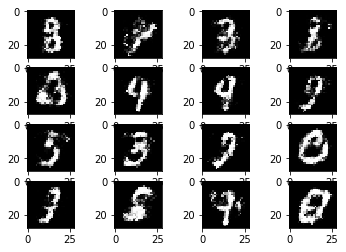

iter: 21000 cost of discriminator -0.26980838 cost of generator -0.42886522
mean predicted prob for actual data: 0.7880420684814453, mean predicted prob for fake data: 0.4288652241230011


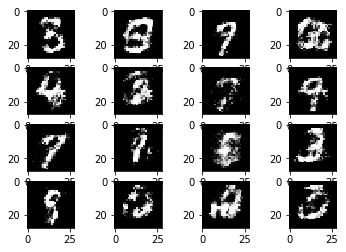

iter: 22000 cost of discriminator -0.25836664 cost of generator -0.40324223
mean predicted prob for actual data: 0.7203823924064636, mean predicted prob for fake data: 0.40324223041534424


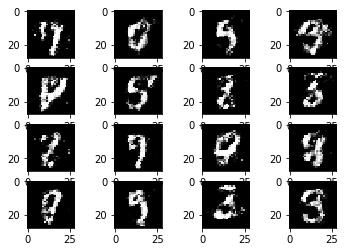

iter: 23000 cost of discriminator -0.18681966 cost of generator -0.46918046
mean predicted prob for actual data: 0.7769141793251038, mean predicted prob for fake data: 0.46918046474456787


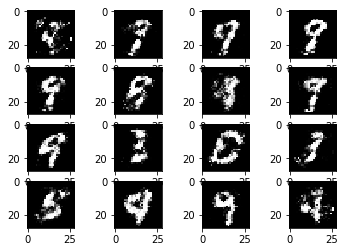

iter: 24000 cost of discriminator -0.25312564 cost of generator -0.42231137
mean predicted prob for actual data: 0.7570227384567261, mean predicted prob for fake data: 0.42231136560440063


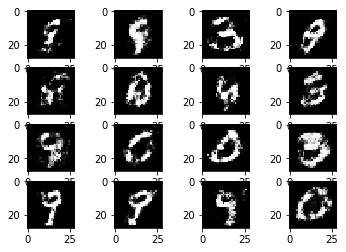

iter: 25000 cost of discriminator -0.27748132 cost of generator -0.30979517
mean predicted prob for actual data: 0.6619361639022827, mean predicted prob for fake data: 0.30979517102241516


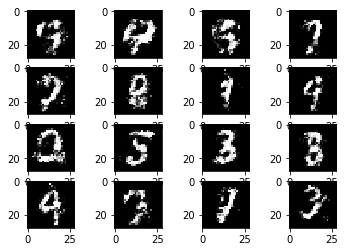

iter: 26000 cost of discriminator -0.20010881 cost of generator -0.42444813
mean predicted prob for actual data: 0.7478576898574829, mean predicted prob for fake data: 0.4244481325149536


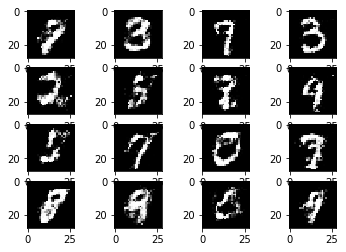

iter: 27000 cost of discriminator -0.25912905 cost of generator -0.32397264
mean predicted prob for actual data: 0.6939706206321716, mean predicted prob for fake data: 0.3239726424217224


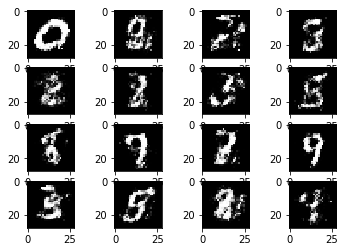

iter: 28000 cost of discriminator -0.26738 cost of generator -0.36805594
mean predicted prob for actual data: 0.7323914766311646, mean predicted prob for fake data: 0.36805593967437744


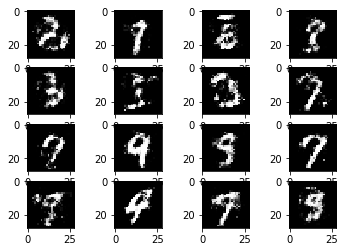

iter: 29000 cost of discriminator -0.24531558 cost of generator -0.3812514
mean predicted prob for actual data: 0.7421231269836426, mean predicted prob for fake data: 0.38125139474868774


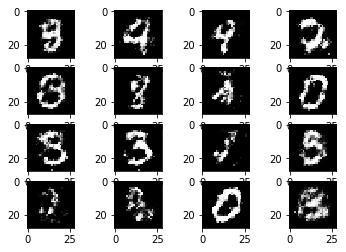

iter: 30000 cost of discriminator -0.23395665 cost of generator -0.43303978
mean predicted prob for actual data: 0.7610927820205688, mean predicted prob for fake data: 0.4330397844314575


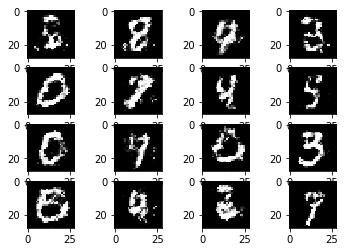

iter: 31000 cost of discriminator -0.17781925 cost of generator -0.41142887
mean predicted prob for actual data: 0.7560184001922607, mean predicted prob for fake data: 0.41142886877059937


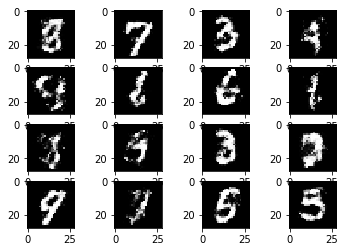

iter: 32000 cost of discriminator -0.32890666 cost of generator -0.36920828
mean predicted prob for actual data: 0.7475035786628723, mean predicted prob for fake data: 0.36920827627182007


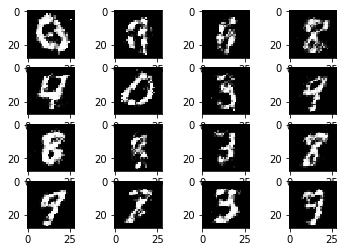

iter: 33000 cost of discriminator -0.2858743 cost of generator -0.38349545
mean predicted prob for actual data: 0.7439215779304504, mean predicted prob for fake data: 0.3834954500198364


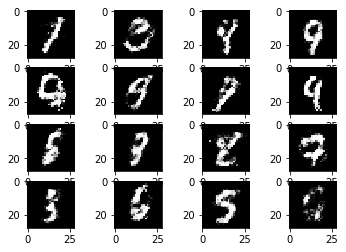

iter: 34000 cost of discriminator -0.2561642 cost of generator -0.38241568
mean predicted prob for actual data: 0.7333365678787231, mean predicted prob for fake data: 0.38241568207740784


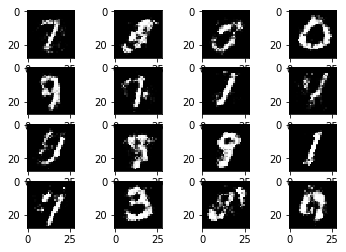

iter: 35000 cost of discriminator -0.31616372 cost of generator -0.3648281
mean predicted prob for actual data: 0.7119753360748291, mean predicted prob for fake data: 0.36482810974121094


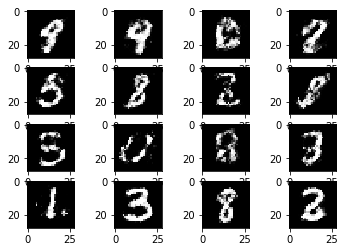

iter: 36000 cost of discriminator -0.27765816 cost of generator -0.3761752
mean predicted prob for actual data: 0.7192133665084839, mean predicted prob for fake data: 0.376175194978714


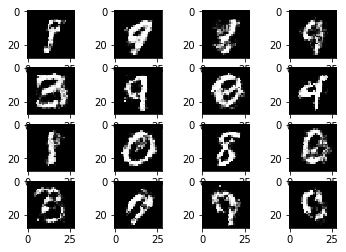

In [ ]:
sess = tf.Session()
sess.run(init)

for i in range(60000):
    for j in range(5):
        batch_x, _ = mnist.train.next_batch(batch_size)
        x_value = batch_x
    # x_value = 2 * batch_x.astype(np.float32) - 1
        z_value = np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32)
        sess.run(d_trainer, feed_dict={x:batch_x, z_noise:z_value, keep_prob:1})

    z_value2 = np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32)
    sess.run(g_trainer, feed_dict={x:x_value, z_noise:z_value2, keep_prob:1})
    
    # c1, c2 = sess.run([disc_loss, gen_loss], feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
    # if np.isnan(c1) or np.isnan(c2):
    #     print ('iter:', i, 'cost of discriminator', c1, 'cost of generator', c2)
    #     break
    # prev_grads = sess.run([disc_grad, gen_grad], feed_dict={x:x_value, z_noise:z_value2, keep_prob:1})
    # prev_weights = sess.run([weights_g, weights_d])
    # prev_loss = sess.run([disc_loss, gen_loss], feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
    # prev_input = batch_x, z_value
    # prev_output = sess.run(out_gen, feed_dict={x:x_value, z_noise:z_value2, keep_prob:1})
    
    if (i % 1000 == 0) and (i > 1):
        c1, c2 = sess.run([disc_loss, gen_loss], feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
        print ('iter:', i, 'cost of discriminator', c1, 'cost of generator', c2)
        pdata, pfake = sess.run([tf.reduce_mean(y_data), tf.reduce_mean(y_fake)],
                                feed_dict={x:x_value, z_noise:z_value, keep_prob:1})
        print(f'mean predicted prob for actual data: {pdata}, mean predicted prob for fake data: {pfake}')
        z_sample = np.random.uniform(-1, 1, size=(batch_size, dim)).astype(np.float32)
        out_val_img = sess.run(out_gen, feed_dict={z_noise: z_sample})
        imgs = 0.5*(out_val_img + 1)
        for k in range(16):
            plt.subplot(4, 4, k + 1)
            image = np.reshape(imgs[k], (28,28))
            plt.imshow(image, cmap='gray')
        plt.show()

In [ ]:
fig=plt.figure(figsize=(32, 32), dpi= 80, facecolor='w', edgecolor='k')

for k in range(2):
    for j in range(batch_size):
        plt.subplot(32, 16, k * 256 + j + 1)
        if k == 0:
            image = np.reshape(prev_input[k][j], (28, 28))
        else:
            image = np.reshape(prev_input[k][j], (10, 10))
        plt.imshow(image * 255)
plt.show()


In [ ]:
fig=plt.figure(figsize=(32, 32), dpi= 80, facecolor='w', edgecolor='k')

for j in range(batch_size):
    plt.subplot(16, 16, j + 1)
    image = np.reshape(prev_output[j], (28, 28))
    plt.imshow(image * 255)
plt.show()


In [ ]:
z_sample = np.random.uniform(-1, 1, size=(batch_size,dim)).astype(np.float32)
out_val_img = sess.run(out_gen,feed_dict={z_noise: z_sample})     
img = 0.5*(out_val_img[3,:] + 1)
img = np.reshape(img, (28 , 28))
plt.imshow(img * 255)
plt.show()

In [ ]:
# saver.save(sess, "newgan_",global_step=i)
imgs = 0.5*(out_val_img + 1)
for k in range(36):
    plt.subplot(6,6,k+1)
    image = np.reshape(imgs[k],(28,28))
    plt.imshow(image, cmap='gray')

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()
